In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

In [3]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'
atlasAlignParams_dir = create_if_not_exists('/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignParams')

In [5]:
labels_twoSides = []
labels_twoSides_indices = {}
with open(volume_dir + '/MD589/volume_MD589_annotation_withOuterContour_labelIndices.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        name, index = line.split()
        labels_twoSides.append(name)
        labels_twoSides_indices[name] = int(index)
        
labelMap_sidedToUnsided = {name: name if '_' not in name else name[:-2] for name in labels_twoSides_indices.keys()}
labels_unsided = ['BackG'] + sorted(set(labelMap_sidedToUnsided.values()) - {'BackG', 'outerContour'}) + ['outerContour']
labels_unsided_indices = dict((j, i) for i, j in enumerate(labels_unsided))

from collections import defaultdict

labelMap_unsidedToSided = defaultdict(list)
for name_sided, name_unsided in labelMap_sidedToUnsided.iteritems():
    labelMap_unsidedToSided[name_unsided].append(name_sided)
labelMap_unsidedToSided.default_factory = None

In [6]:
atlas_volume = bp.unpack_ndarray_file(os.path.join(volume_dir, 'MD589/volume_MD589_annotation_withOuterContour.bp'))

atlas_ydim, atlas_xdim, atlas_zdim = atlas_volume.shape
atlas_centroid = np.array([.5*atlas_xdim, .5*atlas_ydim, .5*atlas_zdim])
print atlas_centroid

[ 419.   229.5  267. ]


In [7]:
def parallel_where(name, num_samples=None):
    
    w = np.where(atlas_volume == labels_twoSides_indices[name])
    
    if num_samples is not None:
        n = len(w[0])
        sample_indices = np.random.choice(range(n), min(num_samples, n), replace=False)
        return np.c_[w[1][sample_indices].astype(np.int16), 
                     w[0][sample_indices].astype(np.int16), 
                     w[2][sample_indices].astype(np.int16)]
    else:
        return np.c_[w[1].astype(np.int16), w[0].astype(np.int16), w[2].astype(np.int16)]

t = time.time()

atlas_nzs_full = Parallel(n_jobs=16)(delayed(parallel_where)(name) for name in labels_twoSides[1:])
atlas_nzs_full = {name: nzs for name, nzs in zip(labels_twoSides[1:], atlas_nzs_full)}

sys.stderr.write('load atlas: %f seconds\n' % (time.time() - t)) #~ 7s

load atlas: 3.038640 seconds


In [8]:
downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

In [9]:
# single stack

stack = 'MD592'

with open(atlasAlignParams_dir + '/%(stack)s/%(stack)s_3dAlignParams.txt' % {'stack': stack}, 'r') as f:
    lines = f.readlines()
    global_params = np.array(map(float, lines[0].strip().split()))
#     atlas_xdim, atlas_ydim, atlas_zdim  = np.array(map(float, lines[1].strip().split()))
    atlas_centroid = np.array(map(float, lines[2].strip().split()))
    test_xdim, test_ydim, test_zdim = np.array(map(float, lines[3].strip().split()), np.int)
    test_centroid = np.array(map(float, lines[4].strip().split()))

In [10]:
# !!!! HERE SHOULD TRANSFORM ONLY THE CONTOURS !!!!

atlas_nzs_projected_to_test = {name: transform_points(global_params, pts=nzs, 
                                                c=atlas_centroid, c_prime=test_centroid).astype(np.int16)
                               for name, nzs in atlas_nzs_full.iteritems()}

test_volume_atlas_projected = np.zeros((test_ydim, test_xdim, test_zdim), np.int)

for name in labels_twoSides[1:]:

    test_xs, test_ys, test_zs = atlas_nzs_projected_to_test[name].T
    
    valid = (test_xs >= 0) & (test_ys >= 0) & (test_zs >= 0) & \
    (test_xs < test_xdim) & (test_ys < test_ydim) & (test_zs < test_zdim)

    atlas_xs, atlas_ys, atlas_zs = atlas_nzs_full[name].T
    
    test_volume_atlas_projected[test_ys[valid], test_xs[valid], test_zs[valid]] = \
    atlas_volume[atlas_ys[valid], atlas_xs[valid], atlas_zs[valid]]

del atlas_nzs_projected_to_test

In [ ]:
bp.pack_ndarray_file(test_volume_atlas_projected, 
                     volume_dir + '/%(stack)s/%(stack)s_volume_atlasProjected.bp'%{'stack':stack})

In [14]:
# all stacks

for stack in ['MD594', 'MD585', 'MD593', 'MD592', 'MD590', 'MD591', 'MD595', 'MD598', 'MD602']:
    
    with open(atlasAlignParams_dir + '/%(stack)s/%(stack)s_3dAlignParams.txt' % {'stack': stack}, 'r') as f:
        lines = f.readlines()
        global_params = np.array(map(float, lines[0].strip().split()))
    #     atlas_xdim, atlas_ydim, atlas_zdim  = np.array(map(float, lines[1].strip().split()))
        atlas_centroid = np.array(map(float, lines[2].strip().split()))
        test_xdim, test_ydim, test_zdim = np.array(map(int, lines[3].strip().split()))
        test_centroid = np.array(map(float, lines[4].strip().split()))
        
    atlas_nzs_projected_to_test = {name: transform_points(global_params, pts=nzs, 
                                                    c=atlas_centroid, c_prime=test_centroid).astype(np.int16)
                                   for name, nzs in atlas_nzs_full.iteritems()}

    test_volume_atlas_projected = np.zeros((test_ydim, test_xdim, test_zdim), np.int)

    for name in labels_twoSides[1:]:

        test_xs, test_ys, test_zs = atlas_nzs_projected_to_test[name].T

        valid = (test_xs >= 0) & (test_ys >= 0) & (test_zs >= 0) & \
        (test_xs < test_xdim) & (test_ys < test_ydim) & (test_zs < test_zdim)

        atlas_xs, atlas_ys, atlas_zs = atlas_nzs_full[name].T

        test_volume_atlas_projected[test_ys[valid], test_xs[valid], test_zs[valid]] = \
        atlas_volume[atlas_ys[valid], atlas_xs[valid], atlas_zs[valid]]

    del atlas_nzs_projected_to_test
    
    bp.pack_ndarray_file(test_volume_atlas_projected, 
                         volume_dir + '/%(stack)s/%(stack)s_volume_atlasProjected.bp'%{'stack':stack})

In [11]:
colors = np.loadtxt(os.environ['REPO_DIR'] + '/visualization/100colors.txt')
colors[labels_twoSides_indices['BackG']] = 1.

In [12]:
section_bs_begin, section_bs_end = section_range_lookup[stack]
print section_bs_begin, section_bs_end

(volume_xmin, volume_xmax, volume_ymin, volume_ymax, volume_zmin, volume_zmax) = \
np.loadtxt(os.path.join(volume_dir, '%(stack)s/%(stack)s_scoreVolume_limits.txt' % {'stack': stack}), dtype=np.int)

map_z_to_section = {}
for s in range(section_bs_begin, section_bs_end+1):
    for z in range(int(z_xy_ratio_downsampled*s) - volume_zmin, int(z_xy_ratio_downsampled*(s+1)) - volume_zmin + 1):
        map_z_to_section[z] = s

91 371


0


/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/PIL/Image.py:2224: DecompressionBombWarning: Image size (260896768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


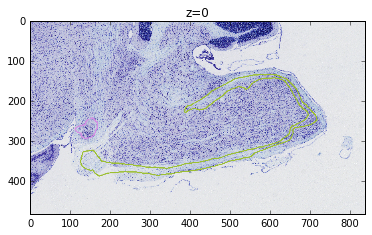

50


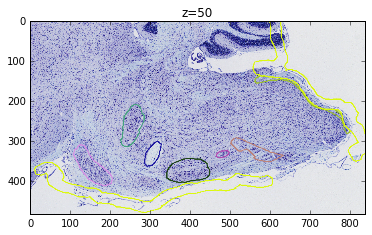

100


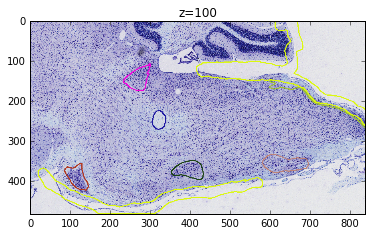

150


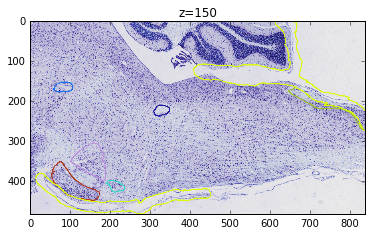

200


KeyboardInterrupt: 

In [13]:
vizs = {}

# annotationsViz_dir = create_if_not_exists(annotationsViz_rootdir + '/' + stack)

dm = DataManager(stack=stack)

for z in range(0, test_zdim, 50):
        
    dm.set_slice(map_z_to_section[z])
    dm._load_image(versions=['rgb-jpg'])
    viz = dm.image_rgb_jpg[::downsample_factor, ::downsample_factor][volume_ymin:volume_ymax+1, 
                                                                     volume_xmin:volume_xmax+1].copy()

    projected_cnts = find_contour_points(test_volume_atlas_projected[...,z])

    for label_ind, cnts in projected_cnts.iteritems():
        for cnt in cnts:
            cv2.polylines(viz, [cnt.astype(np.int)], True, tuple((colors[label_ind]*255).astype(np.int)), 2)

#         cv2.imwrite(annotationsViz_dir + '/%(stack)s_%(sec)04d_annotationsProjectedViz_z%(z)04d.jpg' % \
#                     {'stack': stack, 'sec': map_z_to_section[z], 'z': z}, 
#                     img_as_ubyte(viz[..., [2,1,0]]))
    
#     vizs[z] = viz
    
    plt.figure(figsize=(10, 10));
    plt.imshow(viz);
    plt.title('z=%d'%z);
    plt.show();

#         del viz

#     del test_volume_atlas_projected

#     logger.removeHandler(handler)

In [ ]:
display_images_in_grids([vizs[z] for z in range(0, test_zdim, 50)], nc=2, 
                        titles=['z=%d'%z for z in range(0, test_zdim, 50)])